In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans
import os
conn = sqlite3.connect('C:\\Users\\pklen\\Documents\\Sqlite\\DVADBS.db')
df = pd.read_sql_query("SELECT nppes_provider_zip5,nppes_credentials,specialty_description,nppes_provider_state,total_claim_count, opioid_claim_count,opioid_bene_count,opioid_prescriber_rate,beneficiary_age_less_65_count,beneficiary_age_65_74_count,beneficiary_age_75_84_count,beneficiary_age_greater_84_count FROM npi_summary_sample", conn)
#df = pd.read_sql_query("SELECT * FROM npi_summary_sample", conn)
df = df.loc[df['opioid_prescriber_rate'] !='']
df = df.loc[df['opioid_prescriber_rate'] !='']
df = df.loc[df['opioid_claim_count'] != 0]
df['opioid_prescriber_rate'] = pd.to_numeric(df["opioid_prescriber_rate"])
print(df.head())



  nppes_provider_zip5 nppes_credentials                 specialty_description  \
0               40353                MD  Physical Medicine and Rehabilitation   
1               34205              M.D.        Interventional Pain Management   
2               76104              M.D.        Interventional Pain Management   
3               72703                MD  Physical Medicine and Rehabilitation   
4               31909              M.D.                       Pain Management   

  nppes_provider_state  total_claim_count opioid_claim_count  \
0                   KY              34583              20599   
1                   FL              20683              14604   
2                   TX              18386              12792   
3                   AR              19967              12167   
4                   GA              19428              11351   

  opioid_bene_count  opioid_prescriber_rate beneficiary_age_less_65_count  \
0              1936                   59.56        

In [2]:
df_state_ref = pd.read_csv('C:\\Users\\pklen\\Documents\\omsa\\DVA\\Project\\state_reference.csv')
df_comb = pd.merge(df_state_ref,df,  left_on='nppes_provider_state', right_on='nppes_provider_state', how='left')
#Take one state data (small number)
print((df_comb.loc[df_comb['nppes_provider_state'] == 'WY']).reset_index())

    index nppes_provider_state state_name state_region nppes_provider_zip5  \
0   48711                   WY    Wyoming  West Region               82633   
1   48712                   WY    Wyoming  West Region               82001   
2   48713                   WY    Wyoming  West Region               82443   
3   48714                   WY    Wyoming  West Region               82609   
4   48715                   WY    Wyoming  West Region               82520   
..    ...                  ...        ...          ...                 ...   
76  48787                   WY    Wyoming  West Region               82001   
77  48788                   WY    Wyoming  West Region               82633   
78  48789                   WY    Wyoming  West Region               82901   
79  48790                   WY    Wyoming  West Region               82009   
80  48791                   WY    Wyoming  West Region               83001   

   nppes_credentials specialty_description  total_claim_count  

In [3]:
df_state = ((df_comb.loc[df_comb['nppes_provider_state'] == 'WY']).reset_index())

df_state.replace("", 0, inplace=True)
df_state = df_state.drop(['nppes_provider_zip5','state_name','nppes_provider_state','state_region'],1)

print(df_state)


    index nppes_credentials specialty_description  total_claim_count  \
0   48711                MD     Internal Medicine              13176   
1   48712                MD     Internal Medicine              14814   
2   48713              D.O.       Family Practice               4506   
3   48714                MD       Family Practice              16163   
4   48715      RN, MSN, FNP    Nurse Practitioner               2963   
..    ...               ...                   ...                ...   
76  48787                NP    Nurse Practitioner                445   
77  48788              M.D.       General Surgery                137   
78  48789               DDS               Dentist                 84   
79  48790              M.D.    Orthopedic Surgery                 27   
80  48791                MD     Internal Medicine                279   

    opioid_claim_count  opioid_bene_count  opioid_prescriber_rate  \
0                  902                122                    6.85 

    index nppes_credentials specialty_description  total_claim_count  \
0   48711                MD     Internal Medicine              13176   
1   48712                MD     Internal Medicine              14814   
2   48713              D.O.       Family Practice               4506   
3   48714                MD       Family Practice              16163   
4   48715      RN, MSN, FNP    Nurse Practitioner               2963   
..    ...               ...                   ...                ...   
76  48787                NP    Nurse Practitioner                445   
77  48788              M.D.       General Surgery                137   
78  48789               DDS               Dentist                 84   
79  48790              M.D.    Orthopedic Surgery                 27   
80  48791                MD     Internal Medicine                279   

    opioid_claim_count  opioid_bene_count  opioid_prescriber_rate  \
0                  902                122                    6.85 

Text(28.510648871527785, 0.5, 'opioid_bene_count')

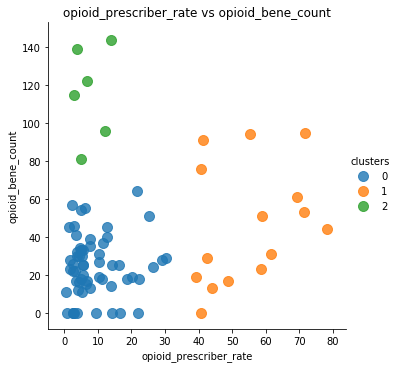

In [4]:
from scipy import stats
df_wy = df_state
clmns = ['opioid_bene_count','opioid_prescriber_rate',]
df_wy_std = stats.zscore(df_wy[clmns])
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_wy_std)
labels = kmeans.labels_
df_wy['clusters'] = labels
print(df_wy)
clmns.extend(['clusters'])
print(df_wy[clmns].groupby(['clusters']).mean())

sns.lmplot('opioid_prescriber_rate', 'opioid_bene_count', 
           data=df_wy, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('opioid_prescriber_rate vs opioid_bene_count')
plt.xlabel('opioid_prescriber_rate')
plt.ylabel('opioid_bene_count')